In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import uproot
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, accuracy_score, roc_curve

import data_loading as dl
from importlib import reload
reload(dl)

<module 'data_loading' from '/uboone/app/users/mmoudgal/pelee/PELEE/data_loading.py'>

In [3]:
# BNB nue samples made by Elena from Afro's generator tutorial

bnb_nue_samples = ['/uboone/data/users/elenag/BuildEventGenerators/samples/nue100000/GENIE_12_1000180400_CC_v3_4_0_G18_10a_02_11a.flat.root',
                   '/uboone/data/users/elenag/BuildEventGenerators/samples/nue100000/NEUT.flat.root',
                   '/uboone/data/users/elenag/BuildEventGenerators/samples/nue100000/GiBUU.flat.root',
                   '/uboone/data/users/elenag/BuildEventGenerators/samples/nue100000/NuWro.flat.root'] 

def make_df(fn):
    up = uproot.open(fn)['FlatTree_VARS']
    df = up.pandas.df(flatten=False)
    return df

In [4]:
# In case you want to inspect each file separately

df_genie = make_df(bnb_nue_samples[0])
df_neut = make_df(bnb_nue_samples[1])
df_gibuu = make_df(bnb_nue_samples[2])
df_nuwro = make_df(bnb_nue_samples[3])

print(len(df_genie), len(df_neut), len(df_gibuu), len(df_nuwro))

100000 100000 62291 100000


In [5]:
# Loading in all the event generator files and concatenating them into one dataframe

df = pd.concat(make_df(fn) for fn in bnb_nue_samples)

In [6]:
df

,Mode,cc,PDGnu,Enu_true,tgt,tgta,tgtz,PDGLep,ELep,CosLep,...,flagNCcoh,flagCC1pip,flagNC1pip,flagCC1pim,flagNC1pim,flagCC1pi0,flagNC1pi0,flagCC0piMINERvA,flagCC0Pi_T2K_AnaI,flagCC0Pi_T2K_AnaII
entry,,,,,,,,,,,,,,,,,,,,,
0,1,1,12,1.367839,1000180400,40,18,11,0.725678,0.132079,...,False,False,False,False,False,False,False,False,False,False
1,11,1,12,1.947980,1000180400,40,18,11,0.941135,0.556985,...,False,False,False,False,False,True,False,False,False,False
2,13,1,12,1.711977,1000180400,40,18,11,0.962747,0.917509,...,False,True,False,False,False,False,False,False,False,False
3,1,1,12,0.745917,1000180400,40,18,11,0.269683,-0.405871,...,False,False,False,False,False,False,False,False,False,False
4,13,1,12,0.896056,1000180400,40,18,11,0.311940,0.274966,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1,1,12,1.951480,1000180400,40,18,11,1.705463,0.953206,...,False,False,False,False,False,False,False,False,False,False
99996,52,0,12,1.232239,1000180400,40,18,12,1.144652,0.923005,...,False,False,False,False,False,False,False,False,False,False
99997,1,1,12,1.995118,1000180400,40,18,11,1.908524,0.970639,...,False,False,False,False,False,False,False,False,False,False


Text(0, 0.5, 'Frequency')

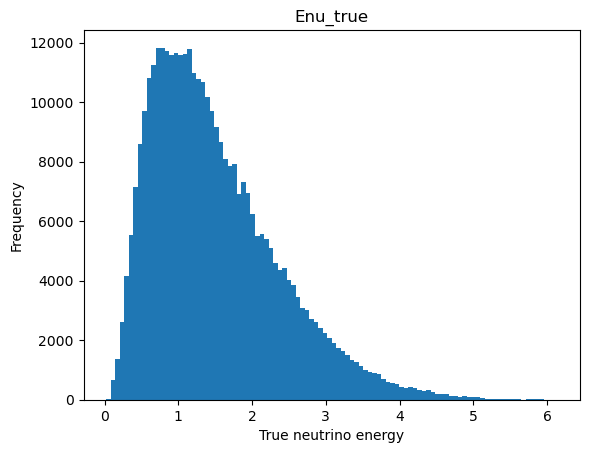

In [7]:
plt.hist(df['Enu_true'], 100)
plt.title('Enu_true')
plt.xlabel('True neutrino energy') # what are the units?
plt.ylabel('Frequency')

In [ ]:
# TO DO:
# - Need signal and background samples
# - Do we need a preselection for the BDT and if so, which variables and values?
# - Feed the signal and background samples into the BDT code structure below

In [ ]:
# The following cells are a BDT code structure written by Anyssa and Luis that can be used for this BDT study

#Split datasets into testing and training datasets
def split_test_train(df, train_frac):

    df_train = df.sample(frac = train_frac)
    df_test=df.drop(df_train.index)

    return df_train, df_test

#--------------------------------------------------

# coldrop = ["reco_shower_dirx", "reco_shower_diry", "reco_shower_dirz"] # if certain columns need to be dropped

# df_sig_train, df_sig_test = split_test_train(df_tridents.drop(columns=coldrop), 0.8)
# df_bkg_train, df_bkg_test = split_test_train(df_bkg.drop(columns=coldrop), 0.6)

df_sig_train, df_sig_test = split_test_train(df_tridents, 0.8)
df_bkg_train, df_bkg_test = split_test_train(df_bkg, 0.6)

print("Events in signal training set (merged): ", len(df_sig_train))
print("Events in signal testing set (merged): ", len(df_sig_test))

print("Events in background training set (merged): ", len(df_bkg_train))
print("Events in background testing set (merged): ", len(df_bkg_test))

#Prepare training and testing datasets

def make_input(df_sig, df_bkg):

    df_sig = shuffle(df_sig).reset_index(drop=True)[slim_bdt_vars]
    df_bkg = shuffle(df_bkg).reset_index(drop=True)[slim_bdt_vars]

    # true label, 1=signal, 0=background
    df_sig.loc[:,'class'] = 1
    df_bkg.loc[:,'class'] = 0

    df = shuffle(pd.concat([df_sig,df_bkg]),random_state=1).reset_index(drop=True)

    x = df[df.columns[:-1]]
    y = df['class']

    return df, x, y

#--------------------------------------------------
df_train, x_train, y_train = make_input(df_sig_train, df_bkg_train)
df_test, x_test, y_test = make_input(df_sig_test, df_bkg_test)

print("Events in full training set: ", len(df_train))
print("Events in full testing set: ", len(df_test))

In [ ]:
use_label_encoder=False

eval_set = [(x_train, y_train), (x_test, y_test)]
eval_metric = ["auc","error","logloss"]

model = xgb.XGBClassifier(use_label_encoder=False,
                          learning_rate=0.01,
                          subsample=0.88,
                          colsample_bytree=0.95,
                          n_estimators = 2000,
                          gamma = 0.75,
                          scale_pos_weight = len(df_bkg_train)/len(df_sig_train),
                          max_depth=5)
model.fit(x_train, y_train, eval_set=eval_set, early_stopping_rounds=300, eval_metric=eval_metric, verbose=False)

# --- take results
results = model.evals_result()                            # takes the results from the BDT training above
n_estimators = len(results['validation_0']['error'])      # number of rounds used for the BDT training
auc_train = results['validation_0']['auc']                # subsample: auc for training
auc_val = results['validation_1']['auc']                  # subsample: auc for validation
error_train = results['validation_0']['error']            # subsample: error for training
error_val = results['validation_1']['error']              # subsample: error for validation

print("Test  Accuracy Score : %.2f"%model.score(x_test, y_test))
print("Train Accuracy Score : %.2f"%model.score(x_train, y_train))
print("Number of rounds: ", n_estimators)

preds_train = model.predict(x_train)
preds_test = model.predict(x_test)

probs_train = model.predict_proba(x_train)
probs_test = model.predict_proba(x_test)


# Save model
model.save_model("bdt_1e1p.json")

In [ ]:
pred_sig_train = model.predict_proba(df_sig_train[slim_bdt_vars])[:,1] # column 1=success, 0=fail
pred_sig_test = model.predict_proba(df_sig_test[slim_bdt_vars])[:,1]
pred_bkg_train = model.predict_proba(df_bkg_train[slim_bdt_vars])[:,1]
pred_bkg_test = model.predict_proba(df_bkg_test[slim_bdt_vars])[:,1]

plt.figure(figsize=(14,4))
nbins=50
xrange=(0,1)

plt.subplot(121)
plt.hist(pred_sig_train, bins=nbins, range=xrange, density=True, color='red', alpha=0.5, label='Sig train (pdf)')
plt.hist(pred_bkg_train, bins=nbins, range=xrange, density=True, color='blue', alpha=0.5, label='Bkg train (pdf)')

hist_sig_test, bins1, _1 = plt.hist(pred_sig_test, bins=nbins, range=xrange, density=True, alpha=0)
mid=0.5*(bins1[1:] + bins1[:-1])
plt.errorbar(x=mid, y=hist_sig_test, xerr=0.5*xrange[1]/nbins, yerr=[0]*nbins, c='firebrick', label='Sig test (pdf)', fmt='o')

hist_bkg_test, bins1, _1 = plt.hist(pred_bkg_test, bins=nbins, range=xrange, density=True, alpha=0)
mid=0.5*(bins1[1:] + bins1[:-1])
plt.errorbar(x=mid, y=hist_bkg_test, xerr=0.5*xrange[1]/nbins, yerr=[0]*nbins, c='navy', label='Bkg test (pdf)', fmt='o')

plt.xlim(xrange)
plt.xlabel('BDT score')
plt.legend(loc='best')

plt.subplot(122)
plt.hist(pred_sig_train, bins=nbins, range=xrange, color='red', alpha=0.5, label='Sig train')
plt.hist(pred_bkg_train, bins=nbins, range=xrange, color='blue', alpha=0.5, label='Bkg train')

hist_sig_test, bins1, _1 = plt.hist(pred_sig_test, bins=nbins, range=xrange, alpha=0)
mid=0.5*(bins1[1:] + bins1[:-1])
plt.errorbar(x=mid, y=hist_sig_test, xerr=0.5*xrange[1]/nbins, yerr=[0]*nbins, c='firebrick', label='Sig test', fmt='o')

hist_bkg_test, bins1, _1 = plt.hist(pred_bkg_test, bins=nbins, range=xrange, alpha=0)
mid=0.5*(bins1[1:] + bins1[:-1])
plt.errorbar(x=mid, y=hist_bkg_test, xerr=0.5*xrange[1]/nbins, yerr=[0]*nbins, c='navy', label='Bkg test', fmt='o')

plt.xlim(xrange)
plt.xlabel('BDT score')
plt.legend(loc='best')

In [ ]:
xgb.plot_importance(model, importance_type="gain")
plt.show()

epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

fig1, ax1 = plt.subplots()
ax1.plot(x_axis, results['validation_0']['auc'], label='Train')
ax1.plot(x_axis, results['validation_1']['auc'], label='Test')
ax1.legend()
ax1.set_ylabel('AUC')
ax1.set_title('XGBoost AUC')

fig1, ax2 = plt.subplots()
ax2.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax2.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax2.legend()
ax2.set_ylabel('Loss')
ax2.set_title('XGBoost Log Loss')


fig1, ax3 = plt.subplots()
ax3.plot(x_axis, results['validation_0']['error'], label='Train')
ax3.plot(x_axis, results['validation_1']['error'], label='Test')
ax3.legend()
ax3.set_ylabel('Classification error')
ax3.set_title('XGBoost Classification Error')
plt.show()